# Mengimpor fungsi library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengambil Dataset dari gdrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Mengimpor Dataset

In [3]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 270
base_dir = os.path.join('gdrive/My Drive/Eye_diseases')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation',
    class_mode= 'categorical')

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)

Found 290 images belonging to 5 classes.
Found 93 images belonging to 5 classes.
Bentuk array dari dataset train (pelatihan) adalah: (270, 224, 224, 3) (270, 5)
Bentuk array dari dataset validation (validasi) adalah: (93, 224, 224, 3) (93, 5)


# Menyimpan label

In [4]:

print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Bulging_eyes': 0, 'Crossed_eyes': 1, 'Glaucoma': 2, 'Uveitis': 3, 'cataract': 4}


In [5]:
!cat labels.txt

Bulging_eyes
Crossed_eyes
Glaucoma
Uveitis
cataract

# Membuat model CNN

In [6]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [8]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
]
)

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 14,862,341
Trainable params: 147,653
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
history = model.fit_generator(train_generator, 
                    epochs=20, 
                    validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 2.0331 - acc: 0.1828 - val_loss: 1.8616 - val_acc: 0.4839
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 1.8609 - acc: 0.4517 - val_loss: 1.6080 - val_acc: 0.5054
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 1.4197 - acc: 0.5552 - val_loss: 1.3042 - val_acc: 0.5591
Epoch 4/20
2/2 [==============================] - 1s 325ms/step - loss: 1.3025 - acc: 0.5862 - val_loss: 1.3034 - val_acc: 0.5914
Epoch 5/20
2/2 [==============================] - 1s 320ms/step - loss: 1.2850 - acc: 0.5793 - val_loss: 1.2506 - val_acc: 0.6022
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 1.2217 - acc: 0.6241 - val_loss: 1.2126 - val_acc: 0.5591
Epoch 7/20
2/2 [==============================] - 1s 326ms/step - loss: 1.1985 - acc: 0.6207 - val_loss: 1.1732 - val_acc: 0.5484
Epoch 8/20
2/2 [==========

# Menampilkan Hasil Pelatihan

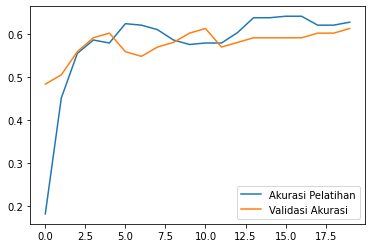

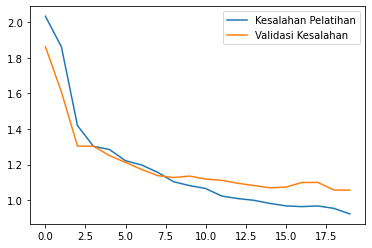

In [10]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# Menggunakan Model

In [11]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [12]:
#Prediksi Label Validasi dengan Pelatihan
n = 50
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0. 0. 0.]
Prediksinya adalah [0.13308172 0.5055216  0.06582467 0.1127013  0.18287067]
